<a href="https://colab.research.google.com/github/Sair-Shaikh/dali_challenge/blob/main/nlp_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install transformers
!pip install torch
!pip install git+https://github.com/huggingface/accelerate
!pip install shap
!pip install seaborn
!pip install matplotlib
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-eakmnh_p
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-eakmnh_p
  Resolved https://github.com/huggingface/accelerate to commit dcde1e93d09abea02a8e7f4a07a2c5734b87b60e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-py

In [ ]:
from transformers import pipeline
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Loading all sentences from the files into a list. Setting up label 0 for Positive, 1 for Negative. 

In [ ]:
data_files = ["amazon-neg.txt", "amazon-pos.txt", "google-neg.txt", "google-pos.txt"]
sentences = []
labels = []
def makeDataArrays(filename, is_pos):
  file = open(filename)
  for line in file:
    sentences.append(line.strip())
    labels.append(is_pos)

for i in range(4):
  makeDataArrays(data_files[i], (i+1)%2)

X = sentences
y = labels

Make the train-test split:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Training BERT:

Download pre-trained BERT and associated tools from HuggingFace: 

In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In initial runs of this model, I found the training was really slow, taking about 1hr 40mins. To speed that up, I realized that the lengths of the sentences varied significantly, with most being much smaller than the max (400+) words. Therefore, we do set padding to False. 

In [ ]:
train_encodings = dict(tokenizer(X_train, truncation=True, padding=False))
test_encodings = dict(tokenizer(X_test, truncation=True, padding=False))
train_encodings["label"] = y_train
test_encodings["label"] = y_test

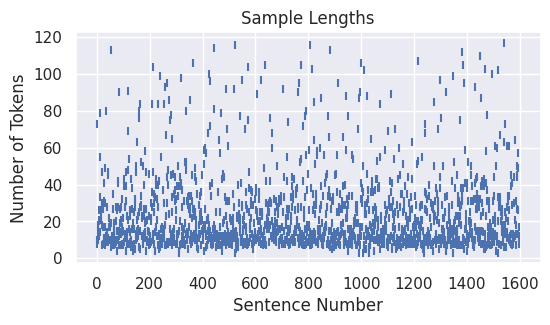

In [ ]:
sents = train_encodings["input_ids"]
unsorted_lens = [len(x) for x in sents]

# Plot scatter plot using matplotlib
sns.set(style='darkgrid')
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (6,3)
plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")
plt.xlabel('Sentence Number')
plt.ylabel('Number of Tokens')
plt.title('Sample Lengths')

plt.show()


As can be seen, most samples are under 50 tokens in length, however there are some with around 120 tokens.

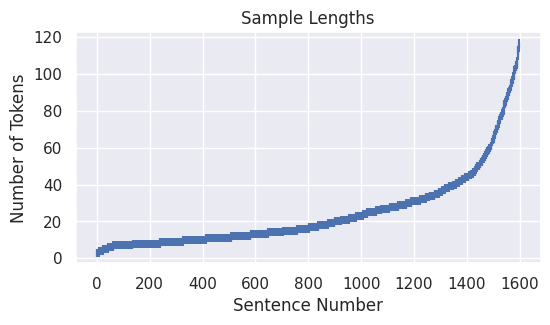

In [ ]:
train_samples = sorted(zip(sents, y_train), key=lambda x: len(x[0]))
sorted_lengths = [len(s[0]) for s in train_samples]

# Plot scatter plot using matplotlib
sns.set(style='darkgrid')
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (6,3)
plt.scatter(range(0, len(sorted_lengths)), sorted_lengths, marker="|")
plt.xlabel('Sentence Number')
plt.ylabel('Number of Tokens')
plt.title('Sample Lengths')

plt.show()


The sorted list can be used for training significantly faster through Smart Batching. However, I did not have enough time to implement methods based off of constructing batches manually such that they have close to the same sizes. I intended to do this by picking a random number, i, and slicing the training data from i to i+batch_size. This ensures that there is some randomness to the training data.


Nevertheless, despite not doing that, we can speed up the training significantly, as will be demonstrated:

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from datasets import Dataset

# Build datasets for ease of use with the model
ds_train = Dataset.from_dict(train_encodings)
ds_test = Dataset.from_dict(test_encodings)

We set up the training arguments as follows:



In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=2,              
    per_device_train_batch_size=10,  
    per_device_eval_batch_size=16,   
    logging_dir='./logs',            
    logging_steps=10,                
    eval_steps=10,
    save_steps=10,
    evaluation_strategy="steps"
)

Set up the Trainer:

In [ ]:
dc = DataCollatorWithPadding(tokenizer, padding=True, return_tensors="pt")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    data_collator=dc,
    )


Train and evaluate model:

In [ ]:
trainer.train()
trainer.evaluate(ds_test)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.36469337344169617,
 'eval_runtime': 98.2264,
 'eval_samples_per_second': 4.072,
 'eval_steps_per_second': 0.255,
 'epoch': 2.0}

Picking model with best loss values and constructing pipeline for easier use with later explanations:

In [ ]:
model = BertForSequenceClassification.from_pretrained("./results/checkpoint-120/")

In [ ]:
from transformers import TextClassificationPipeline

pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
predictions = pipeline.predict(X_test)
predictions

Using the predictions data to get a list of labels and scores. Sorting scores to find the highest and lowest scoring indices. These can be fun to put through the explainer. 

In [176]:
labels_map = { "LABEL_0": 0, "LABEL_1": 1}
def larger_label(pred):
  if pred[0]["score"]>pred[1]["score"]:
    return(pred[0]["label"])
  return(pred[1]["label"])
def larger_score(pred):
  if pred[0]["score"]>pred[1]["score"]:
    return(pred[0]["score"])
  return(pred[1]["score"])

test_labels = [labels_map[larger_label(pred)] for pred in predictions]
test_scores = [(i, larger_score(pred)) for i, pred in enumerate(predictions)]
test_scores_sorted = sorted(test_scores, key=lambda x: x[1], reverse=True)

hi_10_idx = [test_scores_sorted[i][0] for i in range(10)] 
lo_10_idx = [test_scores_sorted[-(i+1)][0] for i in range(10)]
[(X_test[i], y_test[i]) for i in lo_10_idx]

[('there are no pros to working for amazon, besides good insurance.', 0),
 ('NA', 0),
 ('Good Money', 0),
 ('- Velocity', 0),
 ('Your job will be stable if you can put up with the BS.', 0),
 ('depends on team. My team is not a mature team so you kinda lost sometimes. But some of my friends really have a better experience, in their teams.',
  1),
 ('No micromanagement, employees are empowered.', 0),
 ("They've grown.", 1),
 ("Delivering and insisting on the highest standards is not for everyone. If you're working on product launches and it becomes crunch time then you are likely to be working harder than a regular 9-5 job. With that said, though, I've got many friends who manage a good work life balance. Some roles make that easier than others so it's worth choosing wisely. Amazon isn't a company that coddles its employees though...so if???Show More",
  1),
 ("No company is perfect at all things and there are certainly things Amazon can do better. First is correcting the perception that

Very evidently, the sentences that the model has least confidence predicting are very mixed. Some, like "NA" and "- Velocity" are non-sensical. Others like "there are no pros to working for amazon, besides good insurance." are difficult to classify. I will explain a subset of these using shap. 

Confusion Matrix to show the model's accuracy:

In [91]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_labels)

In [92]:
confusion_matrix(test_results[1], y_test)

array([[192,   0],
       [  0, 208]])

As can be observed, the model is 100% accurate.

Saving and downloading the model, for ease of later access:

In [93]:
trainer.save_model("./model")

# Explanations:

Setting up a masker and a predictor to create shap Explainer. I decided to use a masker that masks an entire word, rather than particular tokens. BERT tokenizes words like "happily" into two tokens, one for "happy" and one for "###ly". Since I want explanations on a word level rather than a morpheme level, masking entire words makes sense. Morever, it saves computation time.  

In [123]:
import scipy as sp
import numpy as np
import torch

labels = sorted(model.config.label2id, key=model.config.label2id.get)

# I did not write this function myself. My version returns the exact same output, but does not work. Given more time, I would figure this out. 
# But for now, I am using this function I found in the shap docs. https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html 
def predictor(strings):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=256, truncation=True) for v in strings])
    attention_mask = (tv!=0).type(torch.int64)
    outputs = model(tv, attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

def predictor2(strings):
  predictions = pipeline.predict(strings)
  scores = [[pred[0]["score"], pred[1]["score"]] for pred in predictions ]
  return sp.special.logit(scores)

print(predictor(["This is awesome!", "This is shit"]))
print(predictor2(["This is awesome!", "This is shit"]))



[[ 5.658453  -5.6584516]
 [-6.4526806  6.4526863]]
[[ 5.6584358  -5.65845153]
 [-6.45268013  6.4526865 ]]


In [132]:
import shap
masker = shap.maskers.Text(r"\s")
explainer = shap.Explainer(model=predictor, masker=masker, output_names=["POS", "NEG"])

In [145]:
highs = [X_test[i] for i in hi_10_idx[:5]]
lows = [X_test[i] for i in [lo_10_idx[j] for j in [0, 4, 6, 8, 9]]]
rand = X_test[250:270]
print(lows)

shap_values_lo = explainer(lows, fixed_context=1)
shap_values_hi = explainer(highs, fixed_context=1)
shap_values_rand = explainer(rand, fixed_context=1)

['there are no pros to working for amazon, besides good insurance.', 'Your job will be stable if you can put up with the BS.', 'No micromanagement, employees are empowered.', "Delivering and insisting on the highest standards is not for everyone. If you're working on product launches and it becomes crunch time then you are likely to be working harder than a regular 9-5 job. With that said, though, I've got many friends who manage a good work life balance. Some roles make that easier than others so it's worth choosing wisely. Amazon isn't a company that coddles its employees though...so if???Show More", "No company is perfect at all things and there are certainly things Amazon can do better. First is correcting the perception that there is no work/life balance. i have been in roles in Amazon where there was very little balance and I've been in roles where there is a good balance. What I've come to learn, is it is generally on me to draw those lines and stick to them. The company does ne

  0%|          | 0/110 [00:00<?, ?it/s]


Partition explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]


Partition explainer:  60%|██████    | 3/5 [00:48<00:23, 11.74s/it]

  0%|          | 0/20 [00:00<?, ?it/s]


Partition explainer:  80%|████████  | 4/5 [00:58<00:11, 11.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 100%|██████████| 5/5 [03:15<00:00, 58.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 6it [05:45, 69.02s/it]


  0%|          | 0/462 [00:00<?, ?it/s]


Partition explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer:  60%|██████    | 3/5 [01:34<00:54, 27.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer:  80%|████████  | 4/5 [03:09<00:55, 55.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 100%|██████████| 5/5 [04:26<00:00, 63.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 6it [06:15, 75.19s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]


Partition explainer:  10%|█         | 2/20 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]


Partition explainer:  20%|██        | 4/20 [00:39<02:13,  8.33s/it]

  0%|          | 0/56 [00:00<?, ?it/s]


Partition explainer:  25%|██▌       | 5/20 [00:54<02:47, 11.17s/it]

  0%|          | 0/182 [00:00<?, ?it/s]


Partition explainer:  35%|███▌      | 7/20 [01:25<02:46, 12.81s/it]

  0%|          | 0/12 [00:00<?, ?it/s]


Partition explainer:  40%|████      | 8/20 [01:34<02:16, 11.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer:  45%|████▌     | 9/20 [02:22<04:14, 23.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer:  50%|█████     | 10/20 [03:10<05:09, 30.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer:  55%|█████▌    | 11/20 [05:43<10:18, 68.75s/it]

  0%|          | 0/56 [00:00<?, ?it/s]


Partition explainer:  60%|██████    | 12/20 [05:58<06:58, 52.27s/it]

  0%|          | 0/20 [00:00<?, ?it/s]


Partition explainer:  65%|██████▌   | 13/20 [06:08<04:36, 39.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer:  70%|███████   | 14/20 [06:51<04:02, 40.44s/it]

  0%|          | 0/42 [00:00<?, ?it/s]


Partition explainer:  75%|███████▌  | 15/20 [07:03<02:39, 31.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer:  80%|████████  | 16/20 [08:02<02:39, 40.00s/it]

  0%|          | 0/272 [00:00<?, ?it/s]


Partition explainer:  85%|████████▌ | 17/20 [08:33<01:52, 37.46s/it]

  0%|          | 0/420 [00:00<?, ?it/s]


Partition explainer:  90%|█████████ | 18/20 [09:13<01:16, 38.08s/it]

  0%|          | 0/132 [00:00<?, ?it/s]


Partition explainer:  95%|█████████▌| 19/20 [09:34<00:33, 33.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 100%|██████████| 20/20 [11:11<00:00, 52.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 21it [12:25, 39.25s/it]


In [153]:
  shap.plots.text(shap_values_rand[1])

This particular review was classified as positive. We see that the model considered the words "Amazing benefits" to be greatly positive compared to other words in the sentence. This demonstrates that the model can pick up on strong positive language.

In [160]:
  shap.plots.text(shap_values_rand[10])

This review was classified as negative. One of the clues it picks up on is the word "hard". The model picks up on the connections between words. The word "and" receives a big negative score. In other examples, I noted that "and" also often have a great positive rating. Thus, words like "and" serve to amplify a sentiment - which makes sense. [BAD] AND [BAD] is really [BAD]. 

Next, we plot the mean of features to see which words were most impactful on the scores for positive classification across the subset explained.

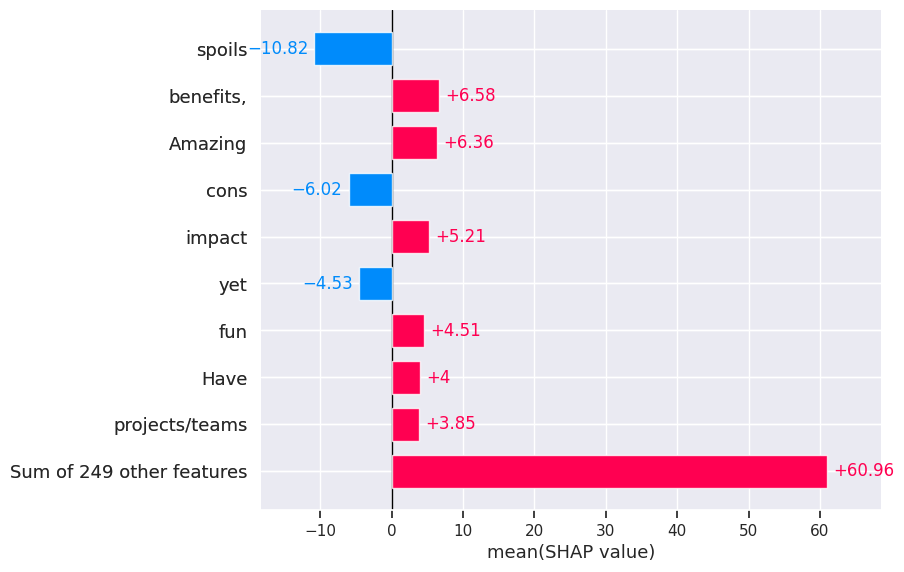

In [168]:
shap.plots.bar(shap_values_rand[:,:,"POS"].mean(0))

The results demonstrate the understanding of the model. Words like "spoils" and "cons" have negative connotations and therefore contribute negatively to the score. Words like "benefits" and "Amazing" have the opposite connotation and therefore the opposite effect. 

Lastly, I want to consider some sentences with the highest and lowest scores.

In [171]:
  shap.plots.text(shap_values_hi)

Interestingly, the 5 sentences BERT most confidently classified were all negative. Looking at these reviews, featuring words like "frustration", we can hypothesize that the strongest, expressive reviews tend to be negative. 

In [174]:
  shap.plots.text(shap_values_lo[1])

Lastly, we consider the following mixed review. This review contains positive words such as "stable", in relation to "job", but also words like "put up" and "BS". Each of these skews the score towards one sentiment. Even though the model classifies this as positive, and the correct label in the data for this sentence is positive, as a human, I would not be so certain. Similar to humans, the model is also less confident in classfying inputs like this. 

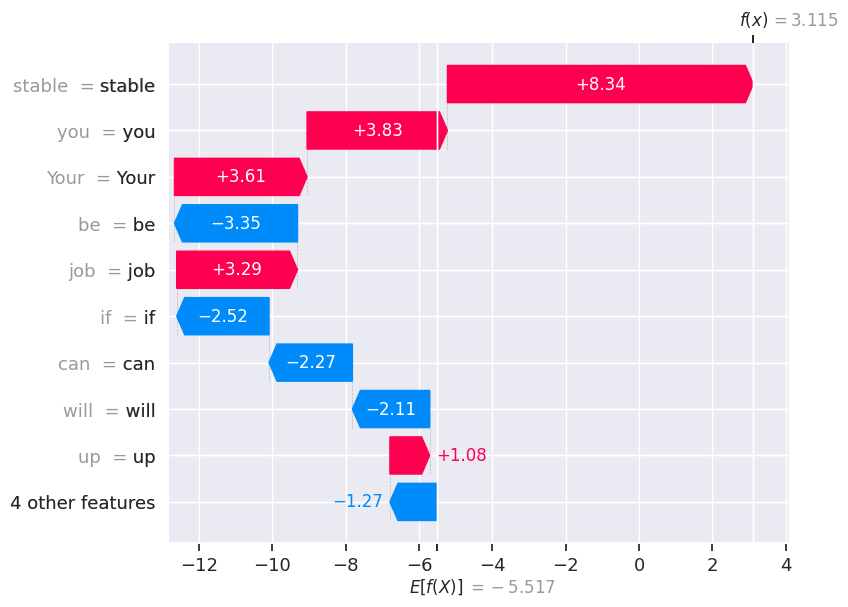

In [182]:
shap.plots.waterfall(shap_values_lo[1,:,"POS"])


In the waterfall plot, we can clearly see how each word moves the score away from the expected score in one direction, based on the word. Additionally, we note the proportions of impacts o each word. 